<a href="https://colab.research.google.com/github/allanrueda/vanilla_gan/blob/main/vanilla_gan_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación de una Red Adversaria Generativa

## Instalar Tensorflow

In [ ]:
!pip install tensorflow

## Importar bibliotecas

In [ ]:
# Un modulo para transformat los arrays de Numpy y crear un ruido aleatorio
import numpy as np
# Un modulo para graficar los datos generados
import matplotlib.pyplot as plt
# Las capas que serán usadas en el Generador y Discriminador
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU

## Crear el conjunto de datos

In [ ]:
# Crear la variable X
X_train = np.linspace(-1, 1, 1000)
# Remodelar la variable X
X_train = X_train.reshape(-1, 1)
# Crear la variable Y tal que y = x
y_train = X_train

## Visualizar el conjunto de datos

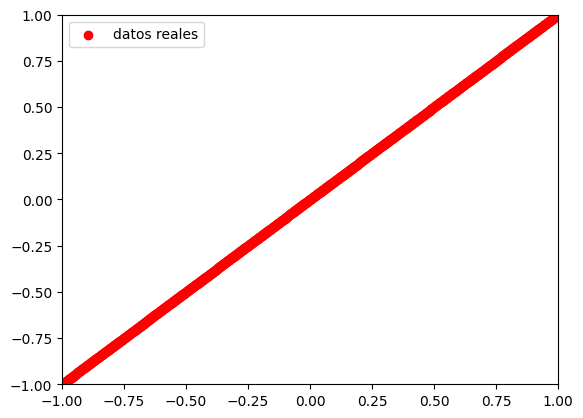

In [ ]:
plt.scatter(X_train, y_train, color = 'red')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.legend(["datos reales"])
plt.show()

## Construir el Generador

In [ ]:
def construir_generador(ruido):
  # Agregar las capra una despues de otra en la secuencia
  modelo = Sequential()
  # Primero conectar completamente la capa
  modelo.add(Dense(16,
                  activation='relu',
                  kernel_initializer='he_uniform',
                  input_dim= ruido))
  # Agregar la función de activación LeakyReLU
  modelo.add(LeakyReLU(alpha=0.01))
  # Capa de salida con forma 2
  modelo.add(Dense(2, activation='linear'))
  return modelo

## Construir el Discriminador

In [ ]:
def construir_discriminador():
  # Agregar las capas una despues de otra en la secuencia
  modelo = Sequential()
  # Primera capa conectada completamente
  modelo.add(Dense(32,
                  activation='relu',
                  kernel_initializer='he_uniform',
                  input_dim=2))
  # Agregar la funcion de activación LeakyReLU
  modelo.add(LeakyReLU(alpha=0.01))
  # Segunda capa conectada completamente
  modelo.add(Dense(8,
                  activation='relu',
                  kernel_initializer='he_uniform'))
  # Agregar la funccion de activacion LeakyReLU
  modelo.add(LeakyReLU(alpha=0.01))
  # La capa de salida con forma 2
  modelo.add(Dense(1, activation='sigmoid'))
  return modelo

## Construcción del Model

In [ ]:
def construir_modelos(ruido):
  # Construir el modelo discriminador
  discriminador = construir_discriminador()
  # Compilar el discriminador
  discriminador.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])
  # Construr el modelo generador
  generador = construir_generador(ruido)
  # Congelar el discriminador durante el proceso de entrenamiento del generador
  discriminador.trainable = False
  # Construir la GAN
  gan = Sequential()
  gan.add(generador)
  gan.add(discriminador)
  # Compilar el modelo GAN
  gan.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  return generador, discriminador, gan

## Definir las funciones de perdidas

In [ ]:
# Definir la funcion de perdida del discriminador
def perdida_discriminador(modelo, X,y):
  # Entrenar el modelo
  return modelo.train_on_batch(X,y)
#Definir la funcion de perdida del generador
def perdida_generador(modelo, X,y):
  # Entrenar el modelo
  return modelo.train_on_batch(X,y)

## Visualizar los datos

In [ ]:
def imprimir_datos(tam_lote, dim_ruido):
  # Create test data
  X_test = np.random.uniform(low=-1,
                             high=1,
                             size=(tam_lote//2, 1))
  y_test = X_test
  # Generate samples
  ruido = np.random.normal(0,
                           1,
                            (tam_lote//2, dim_ruido))
  datos_gen = generador.predict(ruido)
  # Plot generated data
  plt.scatter(X_test,
              y_test,
              color =
              'red')
  plt.scatter(datos_gen[:,0],
              datos_gen[:,1],
              color = 'blue')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.legend(["datos reales", "datos sintéticos"],
             loc = "lower right")
  plt.show()

## Proceso de entrenamiento de la GAN

In [ ]:
def entrenamiento(generador, discriminador, gan, dim_ruido, epocas, tam_lote):
# Enumerar por épocas
  for e in range(epocas):
    # Matriz normal aleatoria para entrada del generador
    ruido = np.random.normal(0, 1, (tam_lote, dim_ruido))
    # Crear puntos de datos falsos mediante el generador.
    datos_sinteticos = generador.predict(ruido)
    # Apilar las variables X e Y horizontalmente para construir el conjunto de datos
    datos_reales = np.hstack((X_train, y_train))
    # Obtenerlos puntos de datos reales aleatorios a partir de los datos de entrenamiento
    datos_reales = datos_reales[np.random.randint(0,
                                                  datos_reales.shape[0],
                                                  size = tam_lote)]
    # Crear las etiquetas reales
    etiquetas_reales = np.ones((tam_lote, 1))*0.9
    # Generar etiquetas falsas, puntos de datos generados como ceros
    etiquetas_falsas = np.zeros((tam_lote, 1))
    # Calcular la pérdida de puntos de datos reales.
    perdida_discriminador_real = perdida_discriminador(
        discriminador, datos_reales, etiquetas_reales)
    # Calcular la pérdida de puntos de datos generados.
    perdida_discriminador_falso = perdida_discriminador(
        discriminador, datos_sinteticos, etiquetas_falsas)
    # Calcular la pérdida total del discriminador
    perdida_disc = 0.5 * np.add(
        perdida_discriminador_real, perdida_discriminador_falso)
    # Generar puntos aleatorios como entrada para el generador.
    x_gan = np.random.normal(0, 1, (tam_lote, dim_ruido))
    # Genera etiquetas reales para la GAN
    y_gan = np.ones((tam_lote, 1))
    # Calcular la pérdida del generador
    perdida_gen = perdida_generador(gan, x_gan, y_gan)
    # Imprimir el progreso
    if e % 50 == 0 or e == epocas-1:
      print('Epoca:', e, ' Pérdida del Generador:', perdida_gen,
            ' Pérdida del Discriminador:', perdida_disc)
      imprimir_datos(tam_lote, dim_ruido)

## Llamar a la función de entrenamiento

4/4 [==============================] - 0s 3ms/step
Epoca: 0  Pérdida del Generador: [0.536597728729248, 0.828125]  Pérdida del Discriminador: [0.81753671 0.09375   ]
2/2 [==============================] - 0s 5ms/step


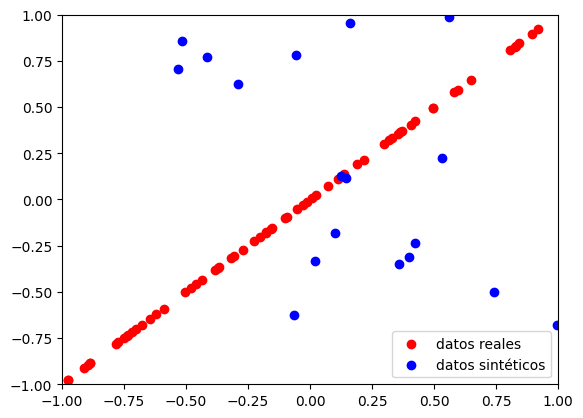

4/4 [==============================] - 0s 3ms/step
Epoca: 50  Pérdida del Generador: [1.1015806198120117, 0.03125]  Pérdida del Discriminador: [0.55456805 0.45703125]
2/2 [==============================] - 0s 9ms/step


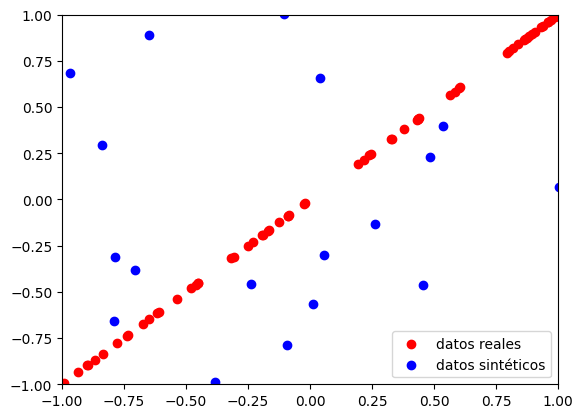

4/4 [==============================] - 0s 3ms/step
Epoca: 100  Pérdida del Generador: [1.084242343902588, 0.1171875]  Pérdida del Discriminador: [0.54126143 0.4453125 ]
2/2 [==============================] - 0s 6ms/step


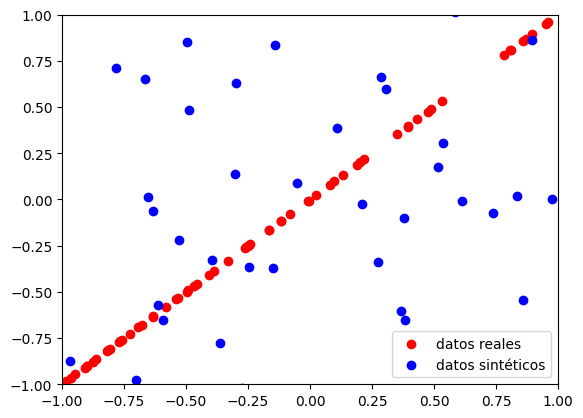

4/4 [==============================] - 0s 4ms/step
Epoca: 150  Pérdida del Generador: [1.1070804595947266, 0.1015625]  Pérdida del Discriminador: [0.56445849 0.4375    ]
2/2 [==============================] - 0s 7ms/step


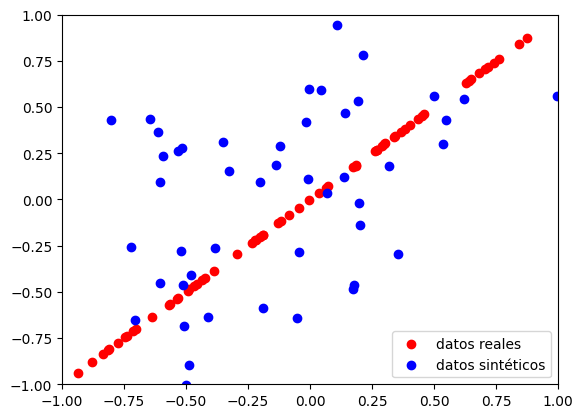

4/4 [==============================] - 0s 3ms/step
Epoca: 200  Pérdida del Generador: [0.9772113561630249, 0.1796875]  Pérdida del Discriminador: [0.56520161 0.37890625]
2/2 [==============================] - 0s 5ms/step


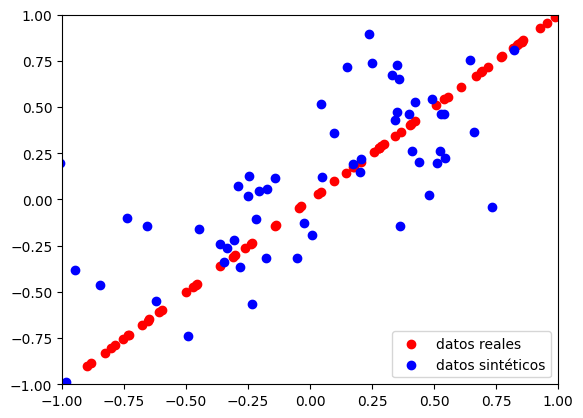

4/4 [==============================] - 0s 4ms/step
Epoca: 250  Pérdida del Generador: [0.921353816986084, 0.2734375]  Pérdida del Discriminador: [0.58039555 0.37890625]
2/2 [==============================] - 0s 6ms/step


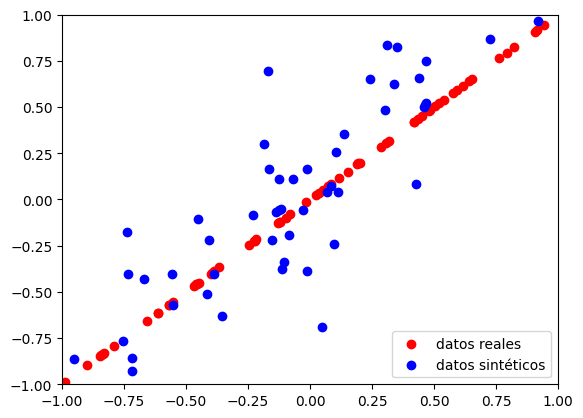

4/4 [==============================] - 0s 5ms/step
Epoca: 300  Pérdida del Generador: [0.8736222982406616, 0.2421875]  Pérdida del Discriminador: [0.60393131 0.40625   ]
2/2 [==============================] - 0s 7ms/step


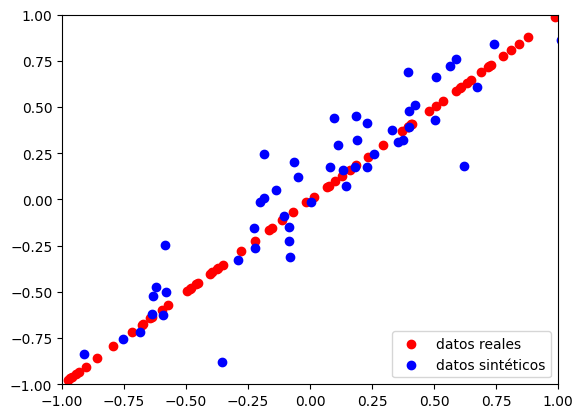

4/4 [==============================] - 0s 3ms/step
Epoca: 350  Pérdida del Generador: [0.7972680926322937, 0.171875]  Pérdida del Discriminador: [0.63971043 0.3671875 ]
2/2 [==============================] - 0s 5ms/step


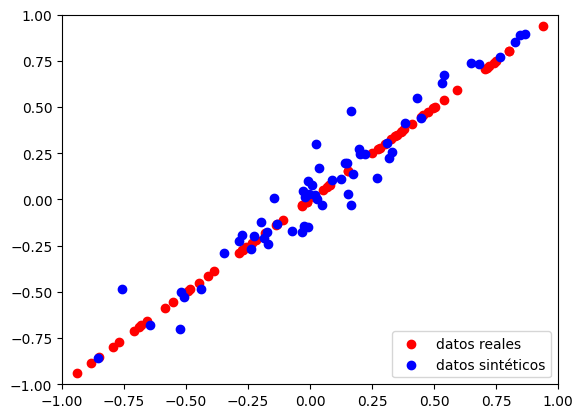

4/4 [==============================] - 0s 3ms/step
Epoca: 400  Pérdida del Generador: [0.7650274038314819, 0.0703125]  Pérdida del Discriminador: [0.66264307 0.40625   ]
2/2 [==============================] - 0s 10ms/step


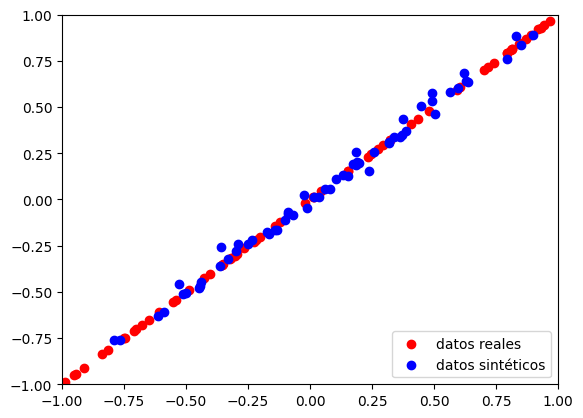

4/4 [==============================] - 0s 3ms/step
Epoca: 450  Pérdida del Generador: [0.7625276446342468, 0.0]  Pérdida del Discriminador: [0.6811592 0.5      ]
2/2 [==============================] - 0s 5ms/step


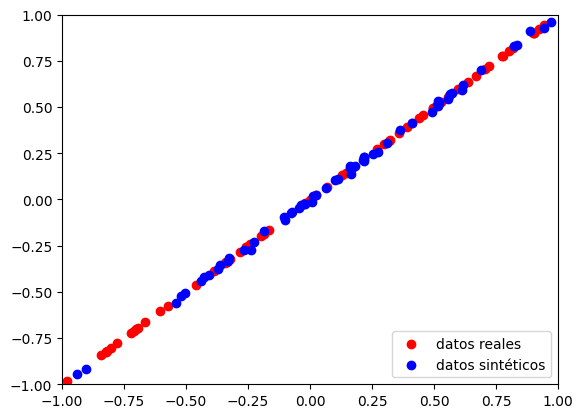

4/4 [==============================] - 0s 5ms/step
Epoca: 500  Pérdida del Generador: [0.7760888338088989, 0.0]  Pérdida del Discriminador: [0.68229684 0.5       ]
2/2 [==============================] - 0s 4ms/step


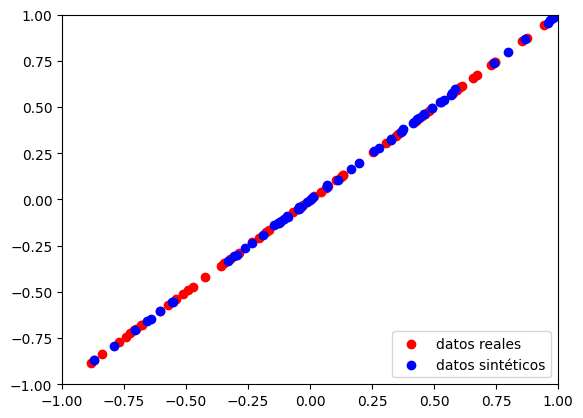

4/4 [==============================] - 0s 3ms/step
Epoca: 550  Pérdida del Generador: [0.7824788689613342, 0.0]  Pérdida del Discriminador: [0.68213674 0.5       ]
2/2 [==============================] - 0s 4ms/step


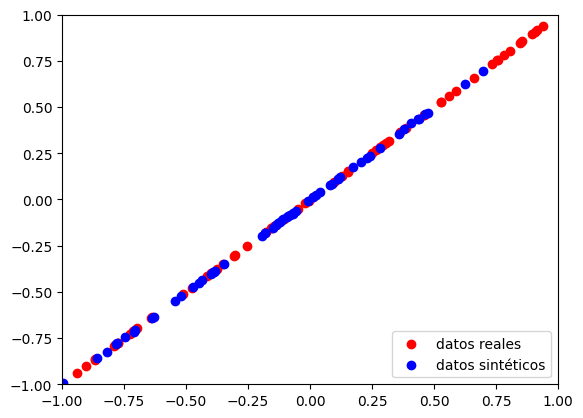

4/4 [==============================] - 0s 5ms/step
Epoca: 599  Pérdida del Generador: [0.8025672435760498, 0.0]  Pérdida del Discriminador: [0.68615165 0.5       ]
2/2 [==============================] - 0s 8ms/step


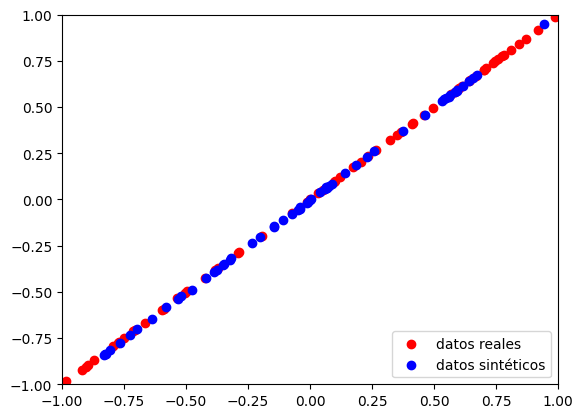

In [ ]:
# Construir el modelo
generador, discriminador, gan = construir_modelos(100)
# Entrenar la GAN
entrenamiento(generador, discriminador, gan, 100, 600, 128)